In [1]:
import numpy as np
import h5py
from tqdm import tqdm
import random
import pandas as pd
import itertools as it
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from utils import global_monotonicity_violation
from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18, class_num_CC18, learner_zoo

In [2]:
file_paths = [  '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5',
                '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5',
                '../dataset/LCDB11_ER_CC18_standardFS_raw.hdf5']
dataset_nofs, dataset_minmaxfs, dataset_standardfs = [h5py.File(fp, 'r')['error_rate'][...] for fp in file_paths]


In [3]:
mono_matrix_y_nofs, mono_matrix_x_nofs = global_monotonicity_violation(dataset_nofs, flat_filter = False, bonferroni = True)
mono_matrix_y_minmaxfs, mono_matrix_x_minmaxfs = global_monotonicity_violation(dataset_minmaxfs, flat_filter = False, bonferroni = True)
mono_matrix_y_standardfs, mono_matrix_x_standardfs = global_monotonicity_violation(dataset_standardfs, flat_filter = False, bonferroni = True)

  0%|          | 0/72 [00:00<?, ?it/s]c:\Users\cyan1\code\lcdb1.1\analysis\utils.py:331: RuntimeWarning: Mean of empty slice
  mean_curve = np.nanmean(curves_group, axis=0)
 74%|███████▎  | 53/72 [00:01<00:00, 42.65it/s]C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 72/72 [00:01<00:00, 46.97it/s]


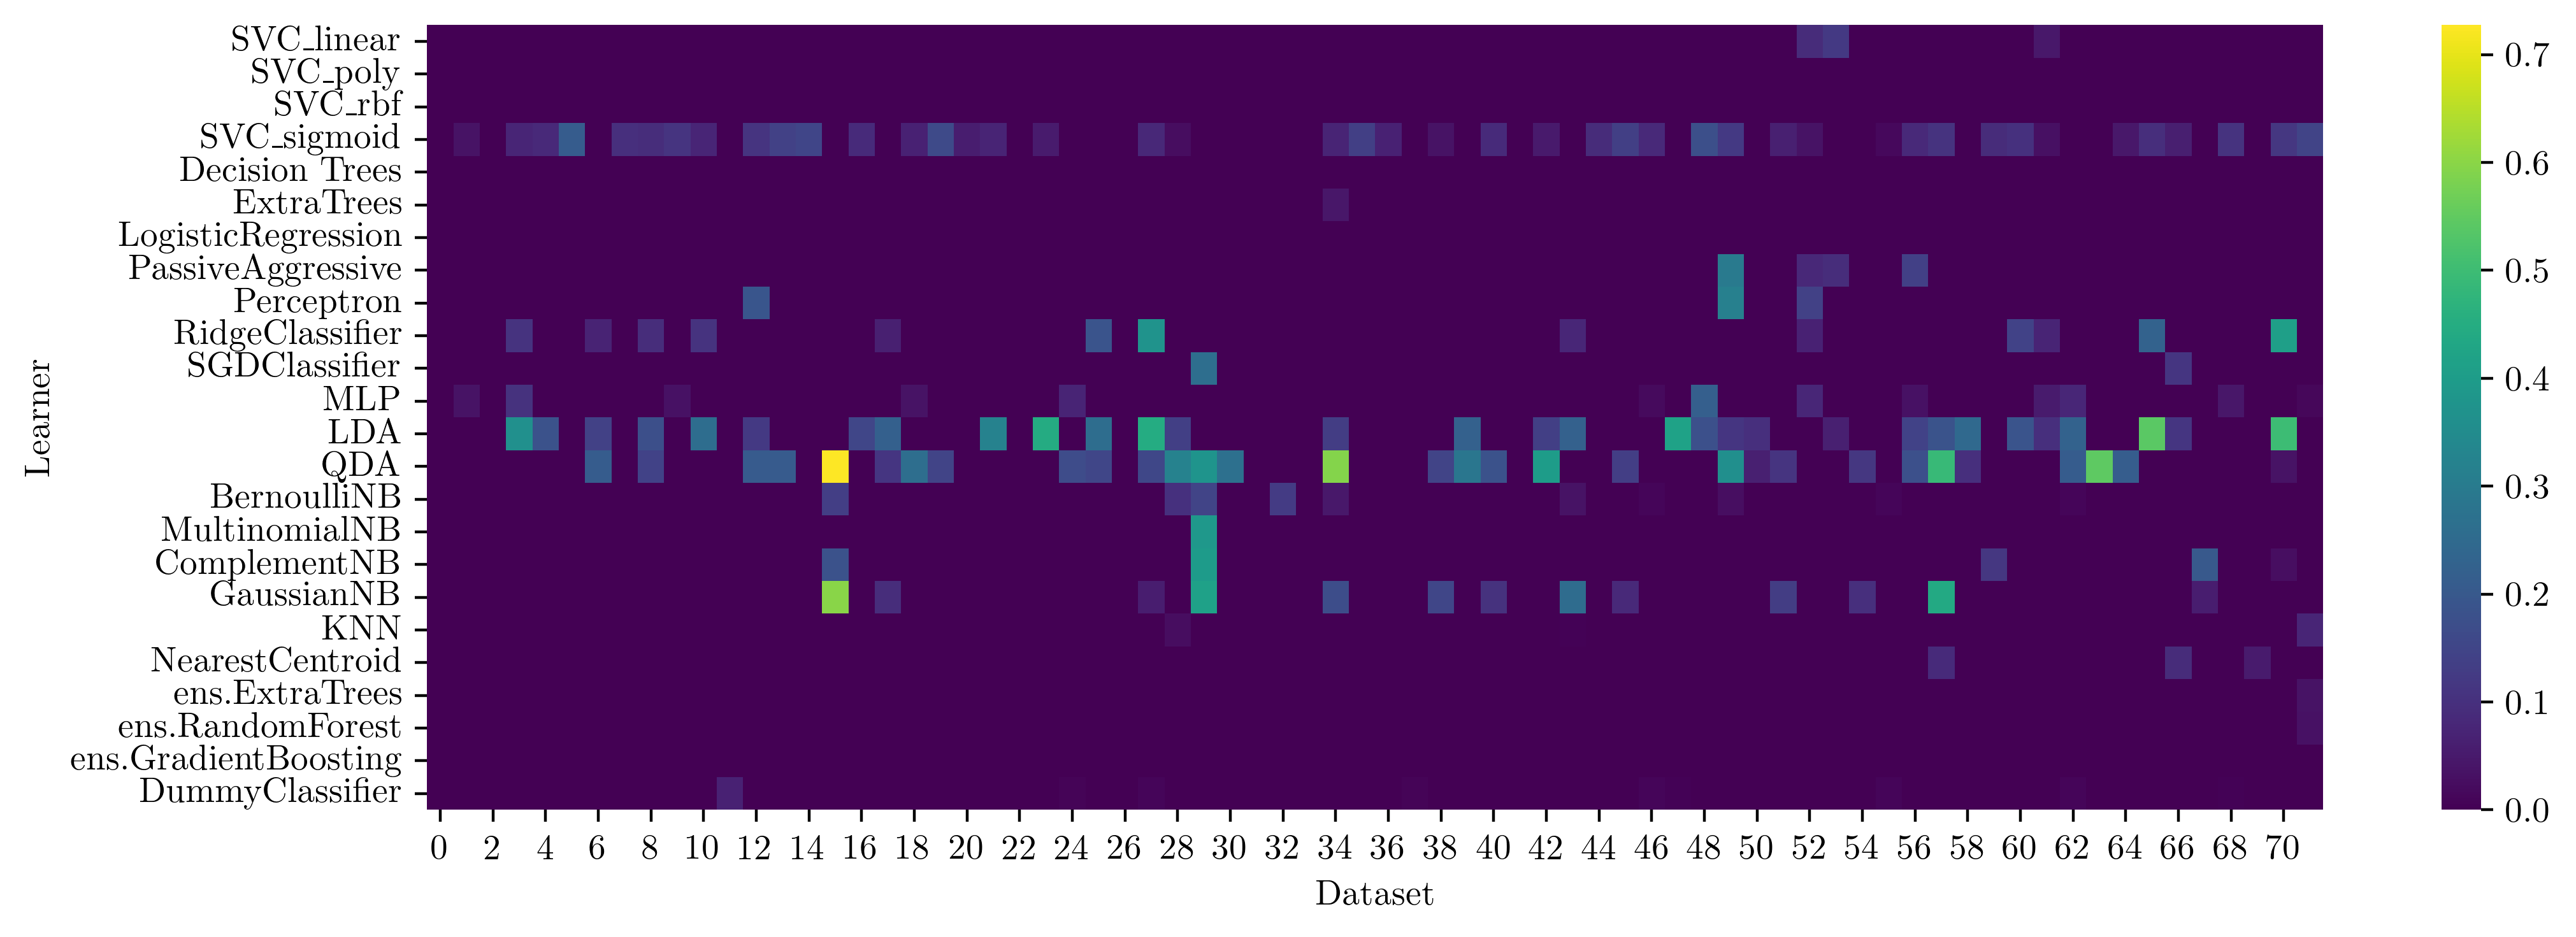

In [4]:
plt.figure(figsize=(12, 4), dpi=400)
ax = sns.heatmap(mono_matrix_y_nofs, cmap="viridis", annot=False, cbar=True)
yticks = range(len(learner_zoo))
ax.set_yticks([y + 0.5 for y in yticks])    # y tick align
ax.set_yticklabels(learner_zoo, rotation=0)
plt.xlabel('Dataset')
plt.ylabel('Learner')
plt.show()

compare learner's mono 
which is bad 

In [5]:
percentages_nofs = (np.sum(mono_matrix_y_nofs > 0, axis=1) / mono_matrix_y_nofs.shape[1]) * 100
percentages_minmaxfs = (np.sum(mono_matrix_y_minmaxfs > 0, axis=1) / mono_matrix_y_minmaxfs.shape[1]) * 100
percentages_standardfs = (np.sum(mono_matrix_y_standardfs > 0, axis=1) / mono_matrix_y_standardfs.shape[1]) * 100


# filter some learner
exclude_indices = [13, 14, 15, 16, 17, 18, 23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

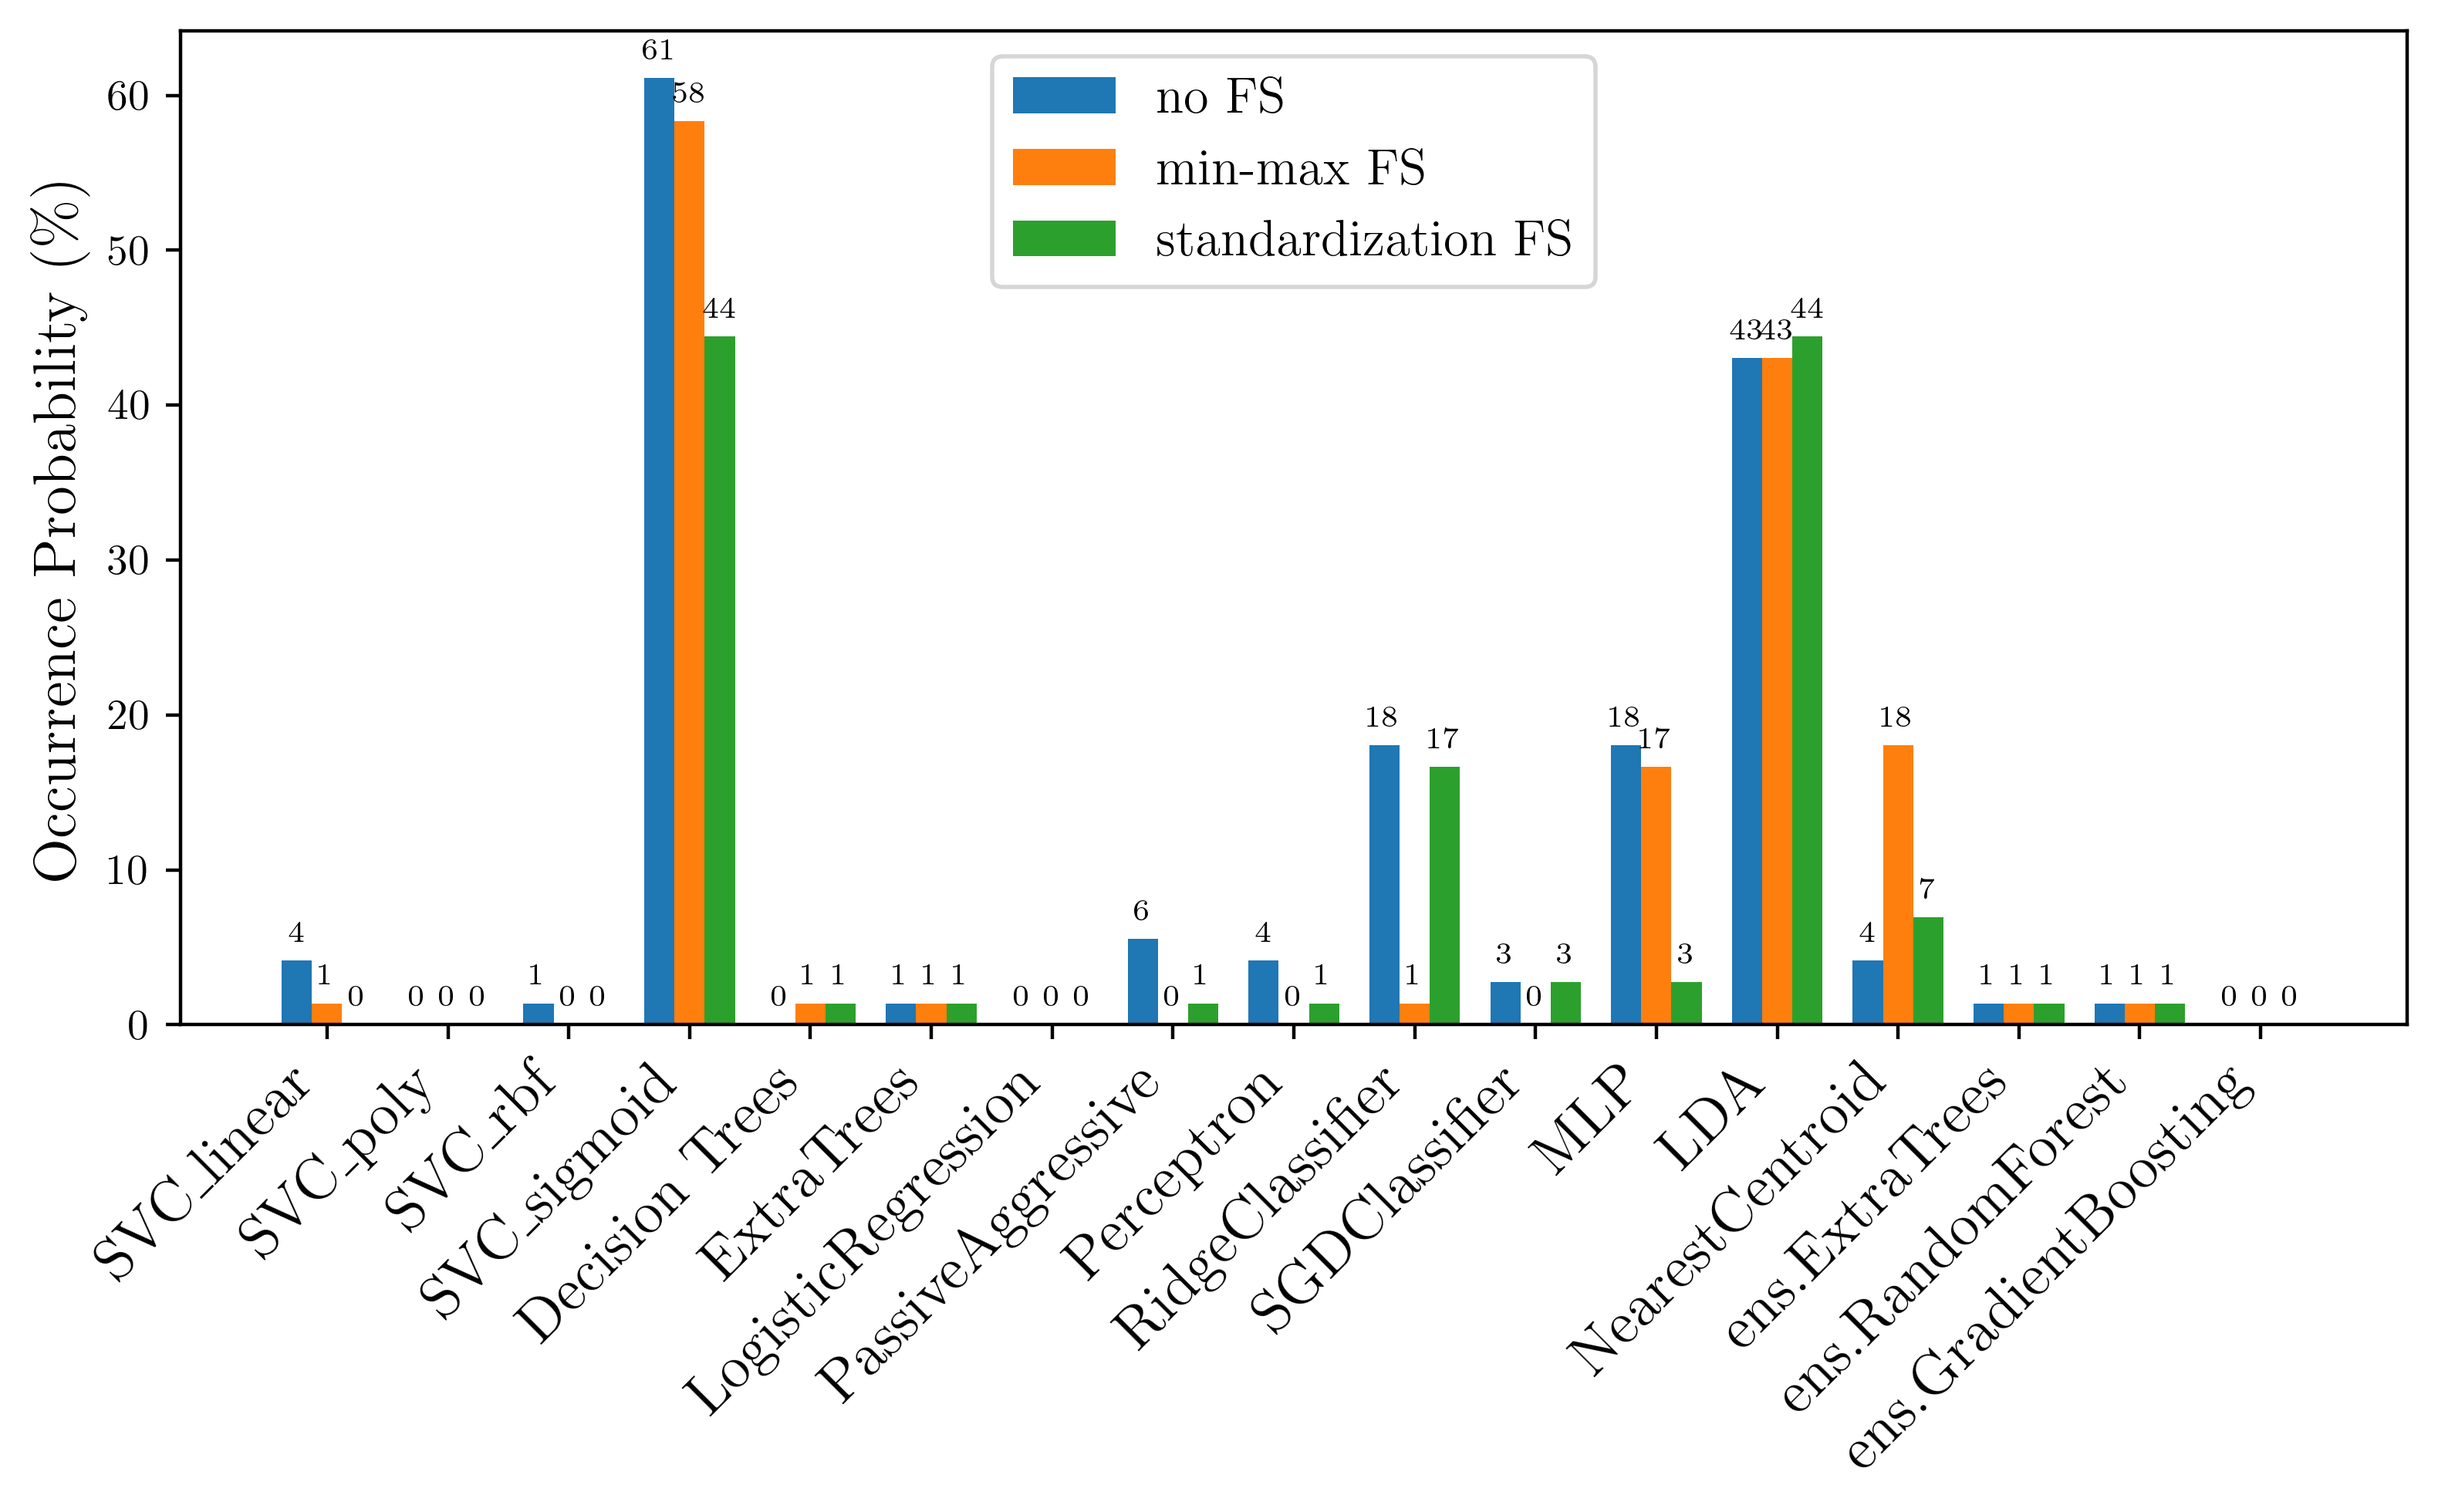

In [6]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Occurrence Probability (\%)', fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(learner_zoo_filtered, rotation=45, ha='right', fontsize = 14)  
ax.legend(loc = 'upper center',fontsize = 12)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


### How to use the violation error and span

C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


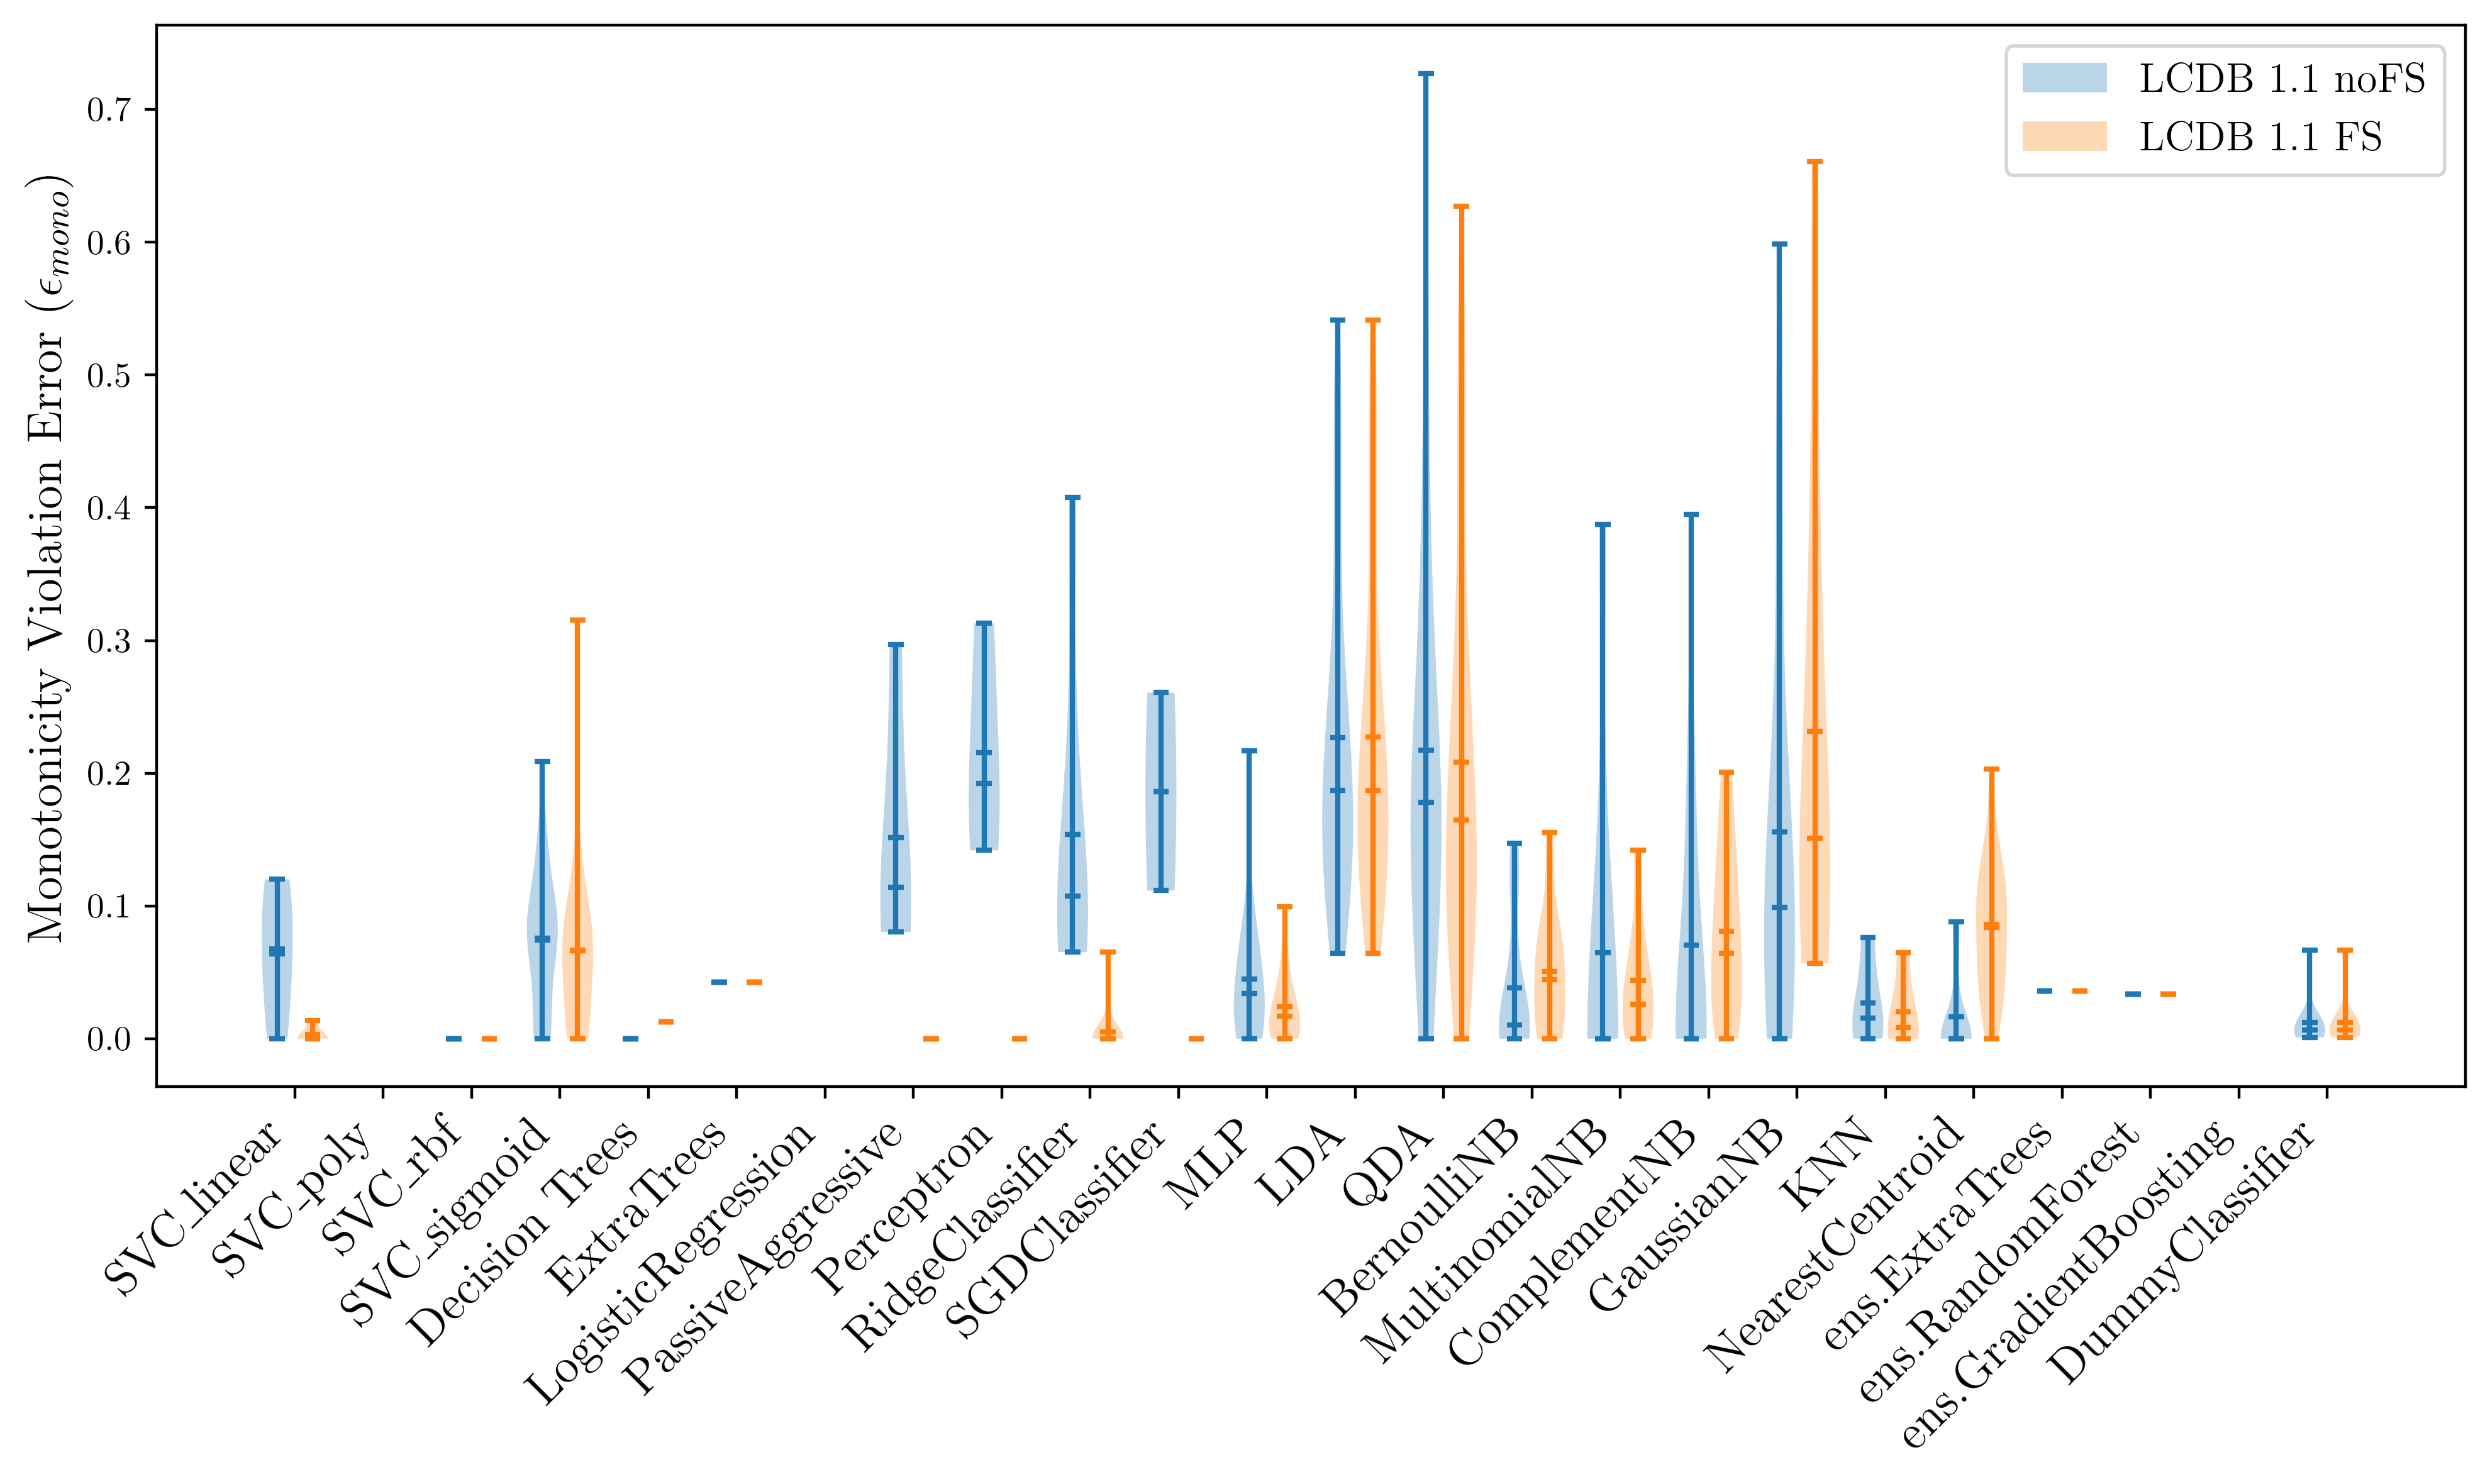

In [9]:
box_data_nofs = [np.array([np.nan, np.nan]) if not np.any(mono_matrix_y_nofs[i]) else [] for i in range(len(learner_zoo))]
box_data_minmaxfs = [np.array([np.nan, np.nan]) if not np.any(mono_matrix_y_minmaxfs[i]) else [] for i in range(len(learner_zoo))]
box_data_standardfs = [np.array([np.nan, np.nan]) if not np.any(mono_matrix_y_standardfs[i]) else [] for i in range(len(learner_zoo))]

for i in range(mono_matrix_y_nofs.shape[0]):
    non_zero_columns = [j for j in range(mono_matrix_y_nofs.shape[1]) 
                        if not (mono_matrix_y_nofs[i, j] == 0 and mono_matrix_y_minmaxfs[i, j] == 0)]
    
    if non_zero_columns:
        box_data_nofs[i] = mono_matrix_y_nofs[i, non_zero_columns]
        box_data_minmaxfs[i] = mono_matrix_y_minmaxfs[i, non_zero_columns]

# zero data to nan
for i in range(len(box_data_nofs)):
    if len(box_data_nofs[i]) < 1:
        box_data_nofs[i] = np.array([np.nan, np.nan])
    if len(box_data_minmaxfs[i]) < 1:
        box_data_minmaxfs[i] = np.array([np.nan, np.nan])


fig, ax = plt.subplots(figsize=(10, 6), dpi=400)

positions = np.arange(len(box_data_nofs))

vio1 = ax.violinplot(box_data_nofs, positions=positions - 0.2, widths=0.35, showmeans=True, showextrema=True, showmedians=True)
vio2 = ax.violinplot(box_data_minmaxfs, positions=positions + 0.2, widths=0.35, showmeans=True, showextrema=True, showmedians=True)

ax.set_ylabel('Monotonicity Violation Error ($\epsilon_{mono}$)', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(learner_zoo, rotation=45, ha='right', fontsize=14)

ax.legend([vio1["bodies"][0], vio2["bodies"][0]], ['LCDB 1.1 noFS', 'LCDB 1.1 FS'], fontsize=12)

fig.tight_layout()
plt.show()


C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


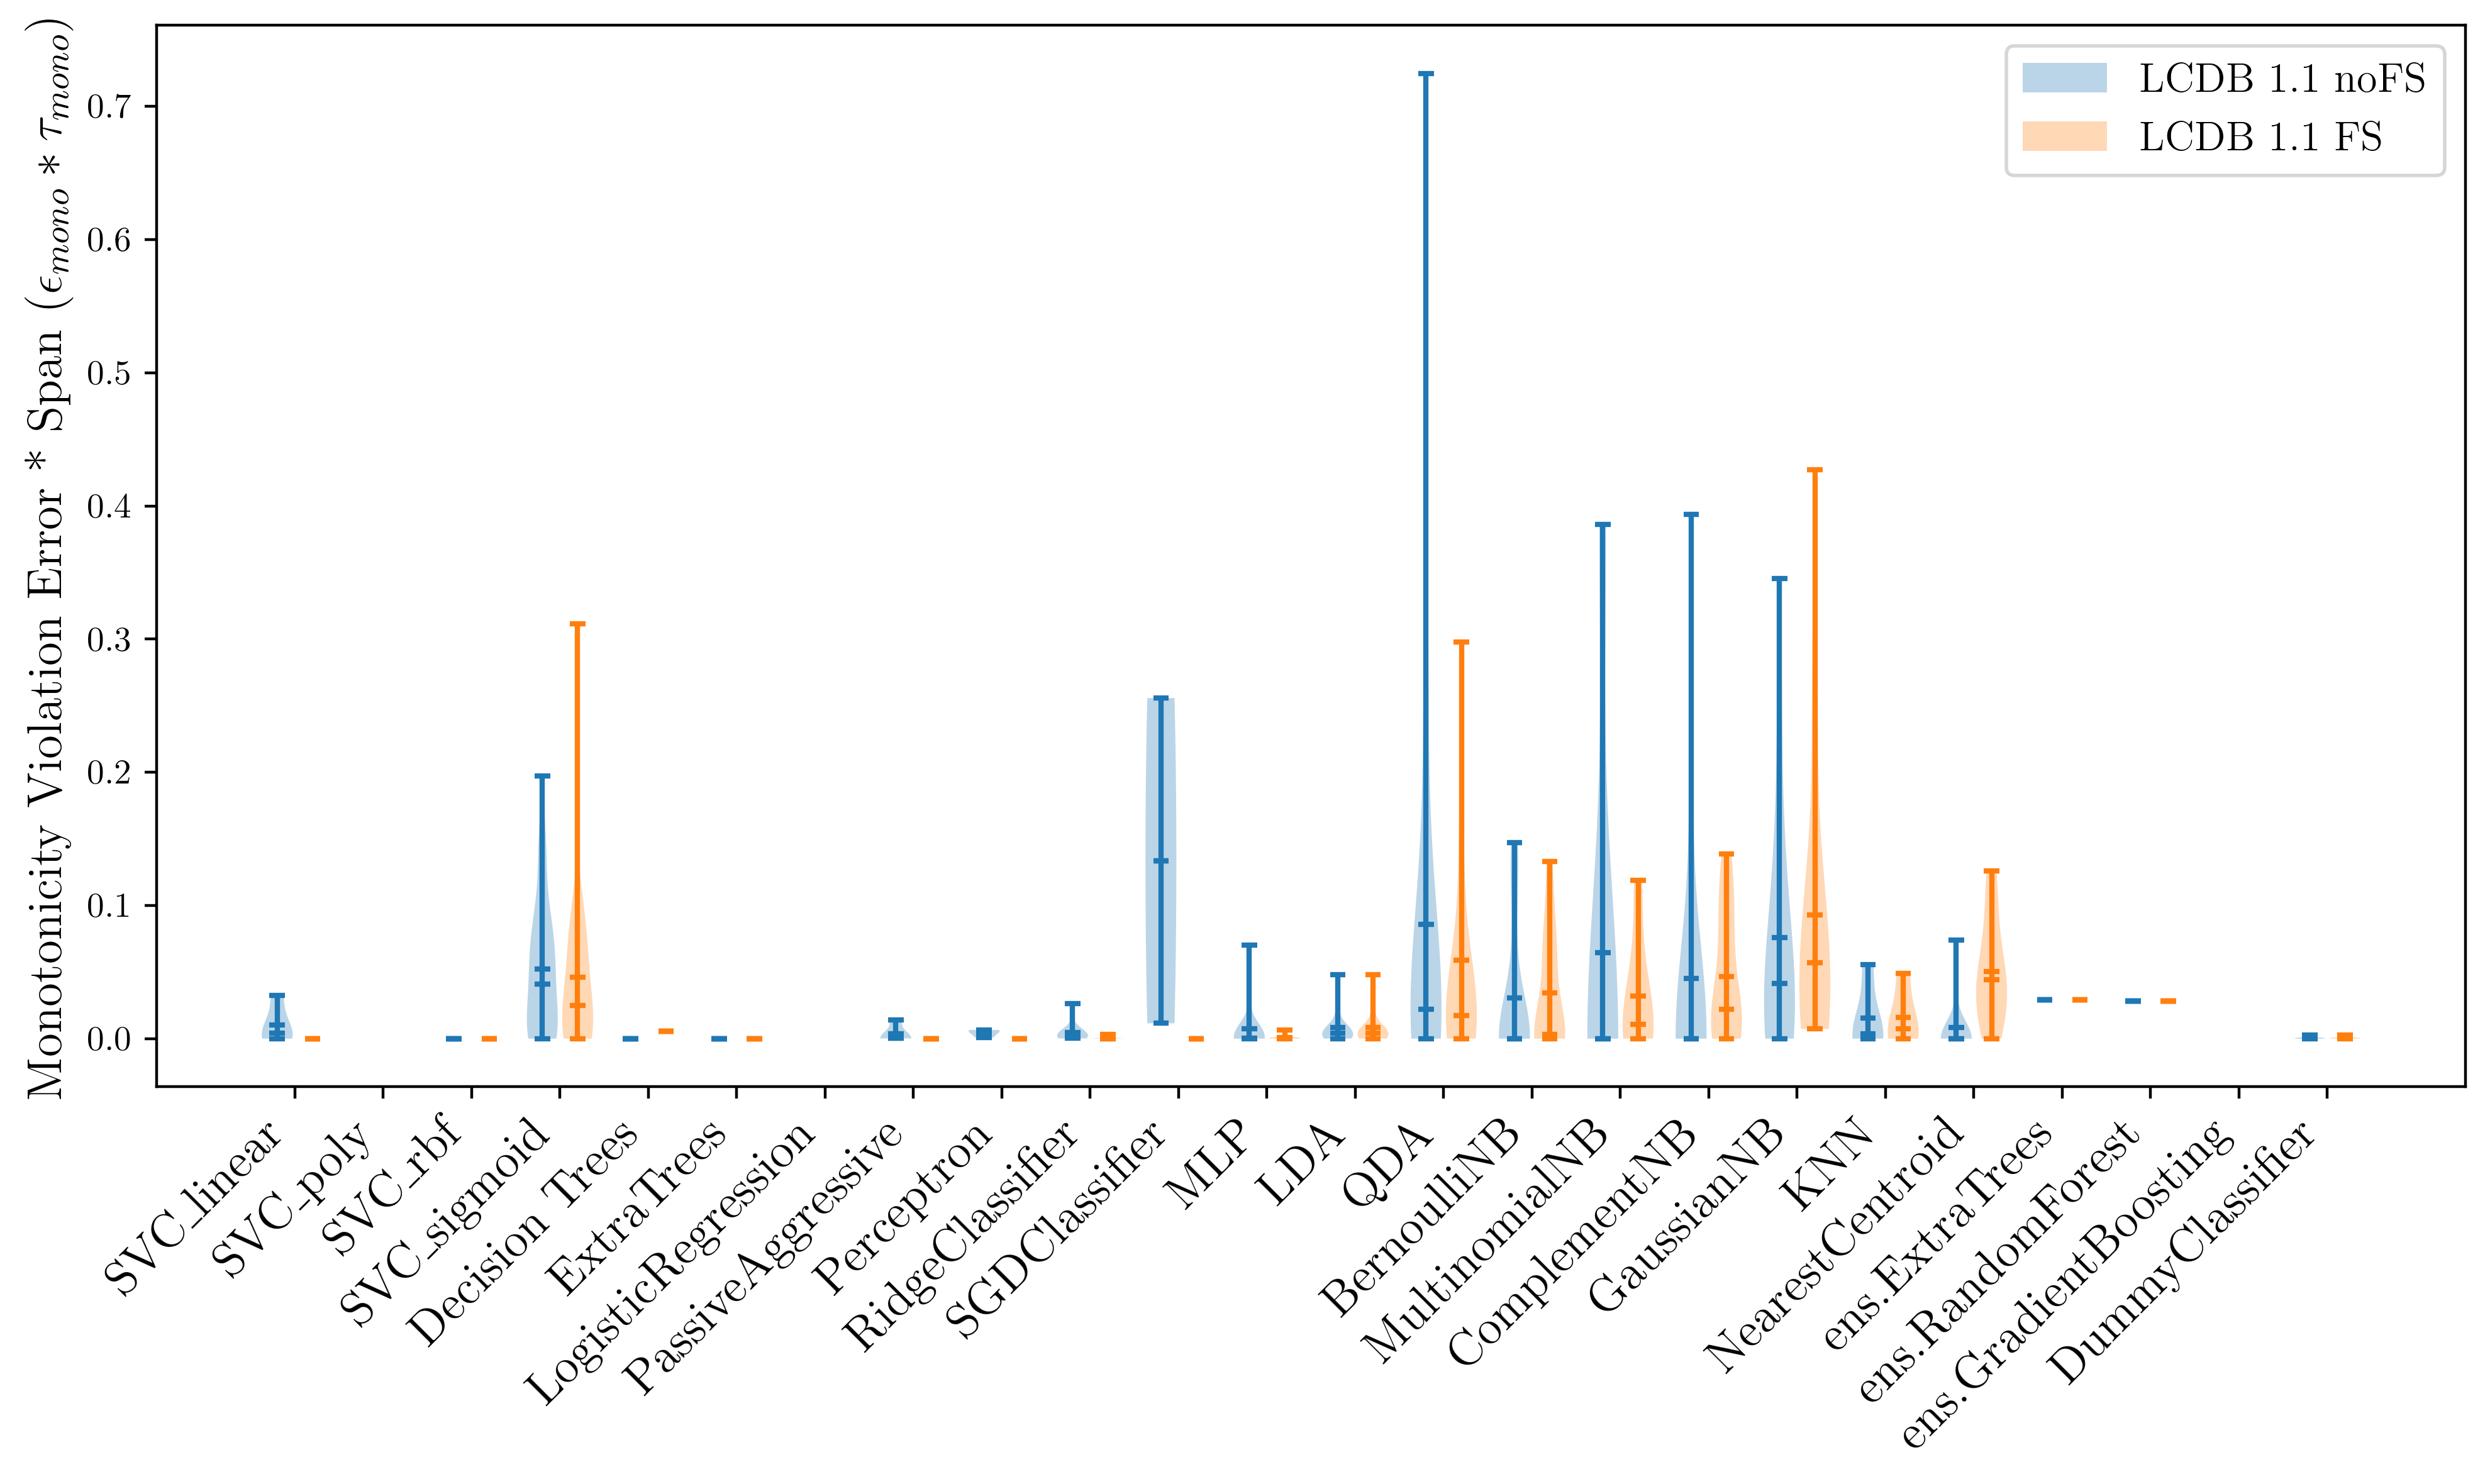

In [11]:
box_data_nofs = [np.array([np.nan, np.nan]) if not np.any(mono_matrix_y_nofs[i] * mono_matrix_x_nofs[i]) else [] for i in range(len(learner_zoo))]
box_data_minmaxfs = [np.array([np.nan, np.nan]) if not np.any(mono_matrix_y_minmaxfs[i] * mono_matrix_x_minmaxfs[i]) else [] for i in range(len(learner_zoo))]

for i in range(mono_matrix_x_nofs.shape[0]):
    non_zero_columns = [j for j in range(mono_matrix_x_nofs.shape[1]) 
                        if not (mono_matrix_x_nofs[i, j] == 0 and mono_matrix_x_minmaxfs[i, j] == 0)]
    
    if non_zero_columns:
        box_data_nofs[i] = mono_matrix_x_nofs[i, non_zero_columns] * mono_matrix_y_nofs[i, non_zero_columns]
        box_data_minmaxfs[i] = mono_matrix_x_minmaxfs[i, non_zero_columns] * mono_matrix_y_minmaxfs[i, non_zero_columns]

# zero data to nan
for i in range(len(box_data_nofs)):
    if len(box_data_nofs[i]) < 1:
        box_data_nofs[i] = np.array([np.nan, np.nan])
    if len(box_data_minmaxfs[i]) < 1:
        box_data_minmaxfs[i] = np.array([np.nan, np.nan])

fig, ax = plt.subplots(figsize=(10, 6), dpi=400)

positions = np.arange(len(box_data_nofs))

vio1 = ax.violinplot(box_data_nofs, positions=positions - 0.2, widths=0.35, showmeans=True, showextrema=True, showmedians=True)
vio2 = ax.violinplot(box_data_minmaxfs, positions=positions + 0.2, widths=0.35, showmeans=True, showextrema=True, showmedians=True)

ax.set_ylabel(r'Monotonicity Violation Error * Span ($\epsilon_{mono} * \tau_{mono}$)', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(learner_zoo, rotation=45, ha='right', fontsize=14)

ax.legend([vio1["bodies"][0], vio2["bodies"][0]], ['LCDB 1.1 noFS', 'LCDB 1.1 FS'], fontsize=12)

fig.tight_layout()
plt.show()


### all results

learner: 12, dataset: 6


C:\Users\cyan1\AppData\Local\Temp\ipykernel_11488\488038229.py:21: RuntimeWarning: Mean of empty slice
  mean_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


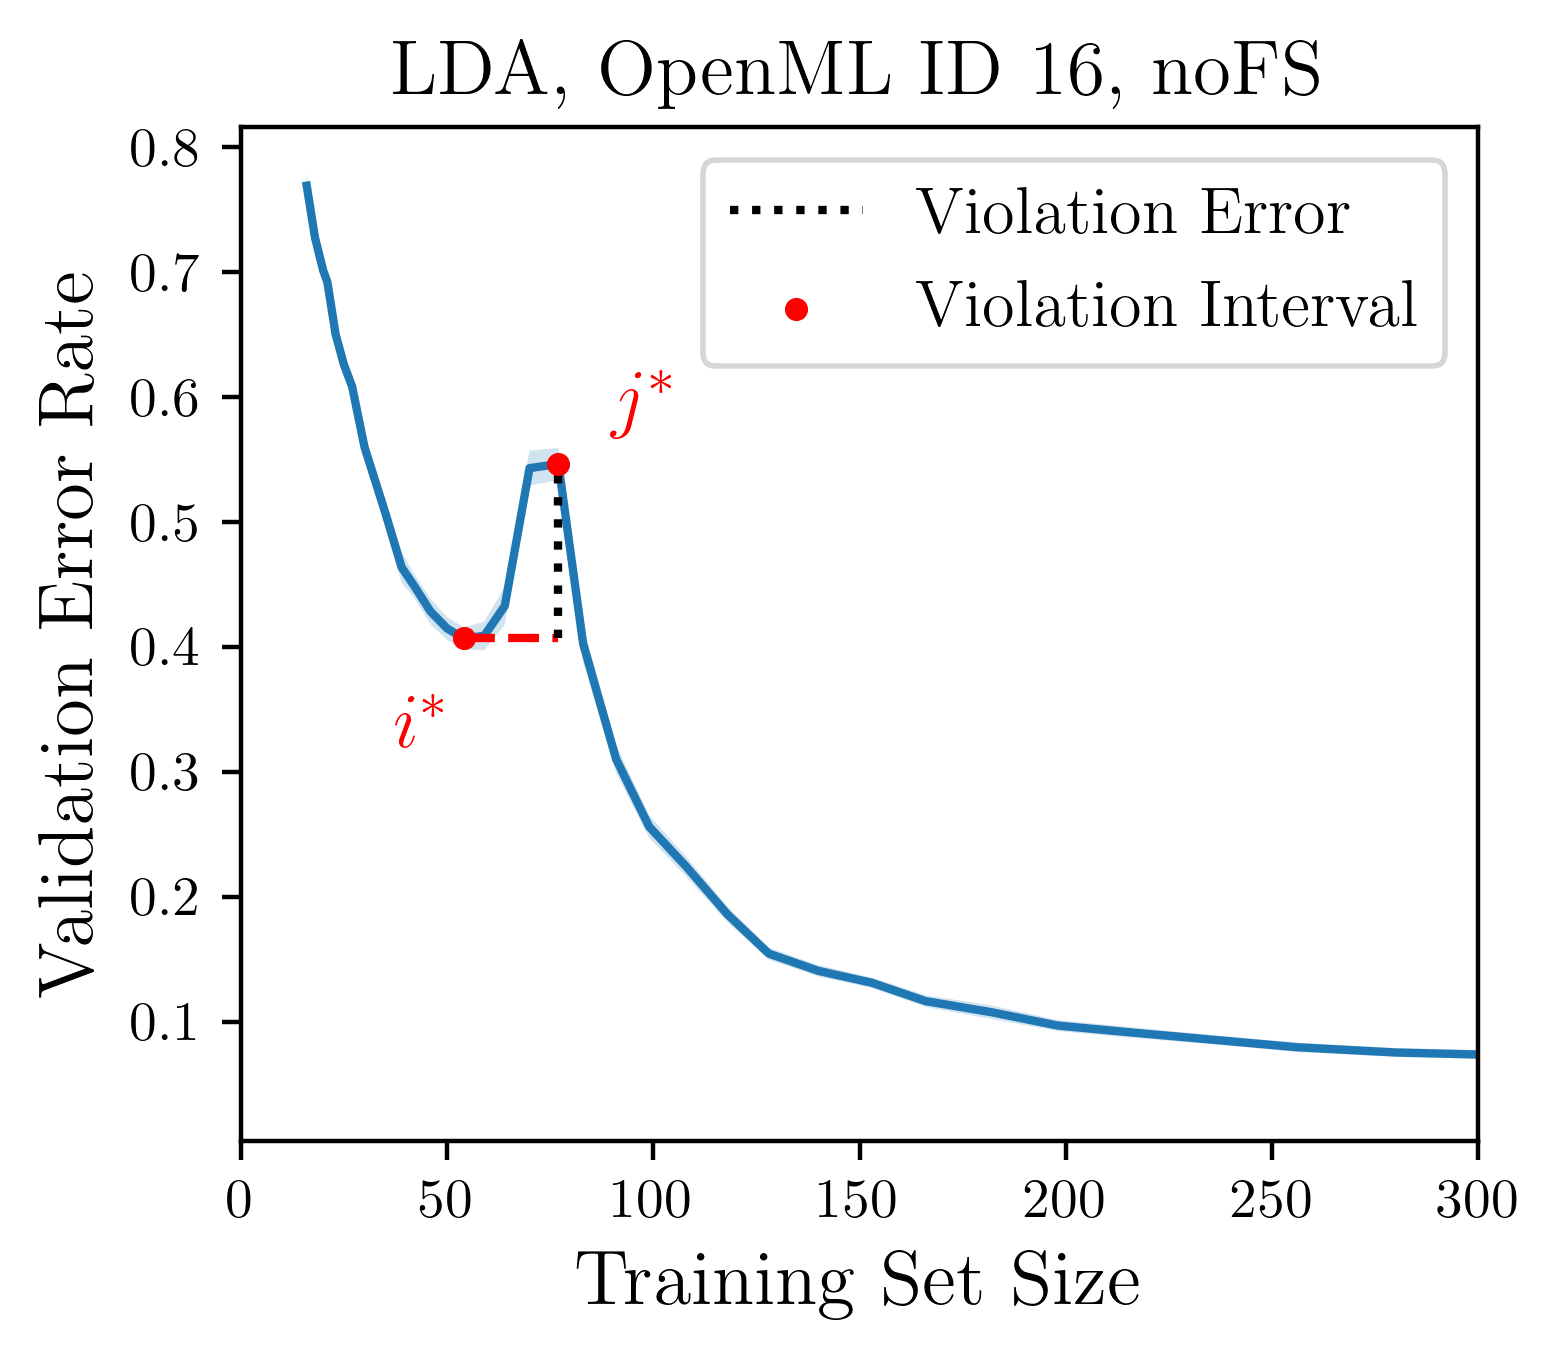

In [4]:
LEARNER = random.randint(0,23)
DATASET = random.randint(0,72)

LEARNER = 11
DATASET = 3

LEARNER = 12
DATASET = 6

# LEARNER = 21
# DATASET = 71

# LEARNER = 3
# DATASET = 13


print(f"learner: {LEARNER}, dataset: {DATASET}")


lc_clean = dataset_nofs[DATASET, LEARNER, :, :, :, 1]
mean_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
se_clean = np.nanstd(lc_clean[:, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean[:, :, :]), axis=(0, 1)))

plt.figure(figsize=(4, 3.5), dpi=400)
plt.plot(anchor_list_denser, mean_clean)#, label="LCDB 1.1 noFS")
plt.fill_between(anchor_list_denser, mean_clean - se_clean, mean_clean + se_clean, alpha=0.2)

num_points = len(mean_clean)
pair_indices = [(i, j) for i in range(num_points - 1) for j in range(i + 1, num_points)]

max_difference = 0 
i_index, j_index = None, None
for (i, j) in pair_indices:
    diff = mean_clean[j] - mean_clean[i]
    if diff > max_difference:
        max_difference = diff
        i_index, j_index = i, j

if i_index is not None and j_index is not None:
    x1, x2 = anchor_list_denser[i_index], anchor_list_denser[j_index]
    y1, y2 = mean_clean[i_index], mean_clean[j_index]

    # h* and j* 
    plt.plot([x1, x2], [y1, y1], 'r--', linewidth=1.5, zorder=4)
    # violation error
    plt.vlines(x2, ymin=y1, ymax=y2, colors='black', linestyles='dotted', linewidth=1.5, zorder=4, label = 'Violation Error')

    plt.scatter([x1, x2], [y1, y2], color='red', s=10, zorder=5, label = 'Violation Interval')  
    
    plt.text(x1-10, y1 - 0.1, '$i^*$', fontsize=14, ha='center', va='bottom', color='red')  
    plt.text(x2+20, y2 + 0.02, '$j^*$', fontsize=14, ha='center', va='bottom', color='red')

# if i_index is not None and j_index is not None:
#     x1, x2 = anchor_list_denser[i_index], anchor_list_denser[j_index]
#     y1, y2 = min(mean_clean[i_index], mean_clean[j_index]), max(mean_clean[i_index], mean_clean[j_index])
#     plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, color='red', alpha=0.3, label='Violation'))

plt.title(f'{learner_zoo[LEARNER]}, OpenML ID {dataset_ids_CC18[DATASET]}, noFS', fontsize=14)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Validation Error Rate', fontsize=14)
plt.xlim(0,300)
# plt.xscale('log')
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('1.png')
plt.show()


C:\Users\cyan1\AppData\Local\Temp\ipykernel_37012\446908788.py:25: RuntimeWarning: Mean of empty slice
  mean_acc_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


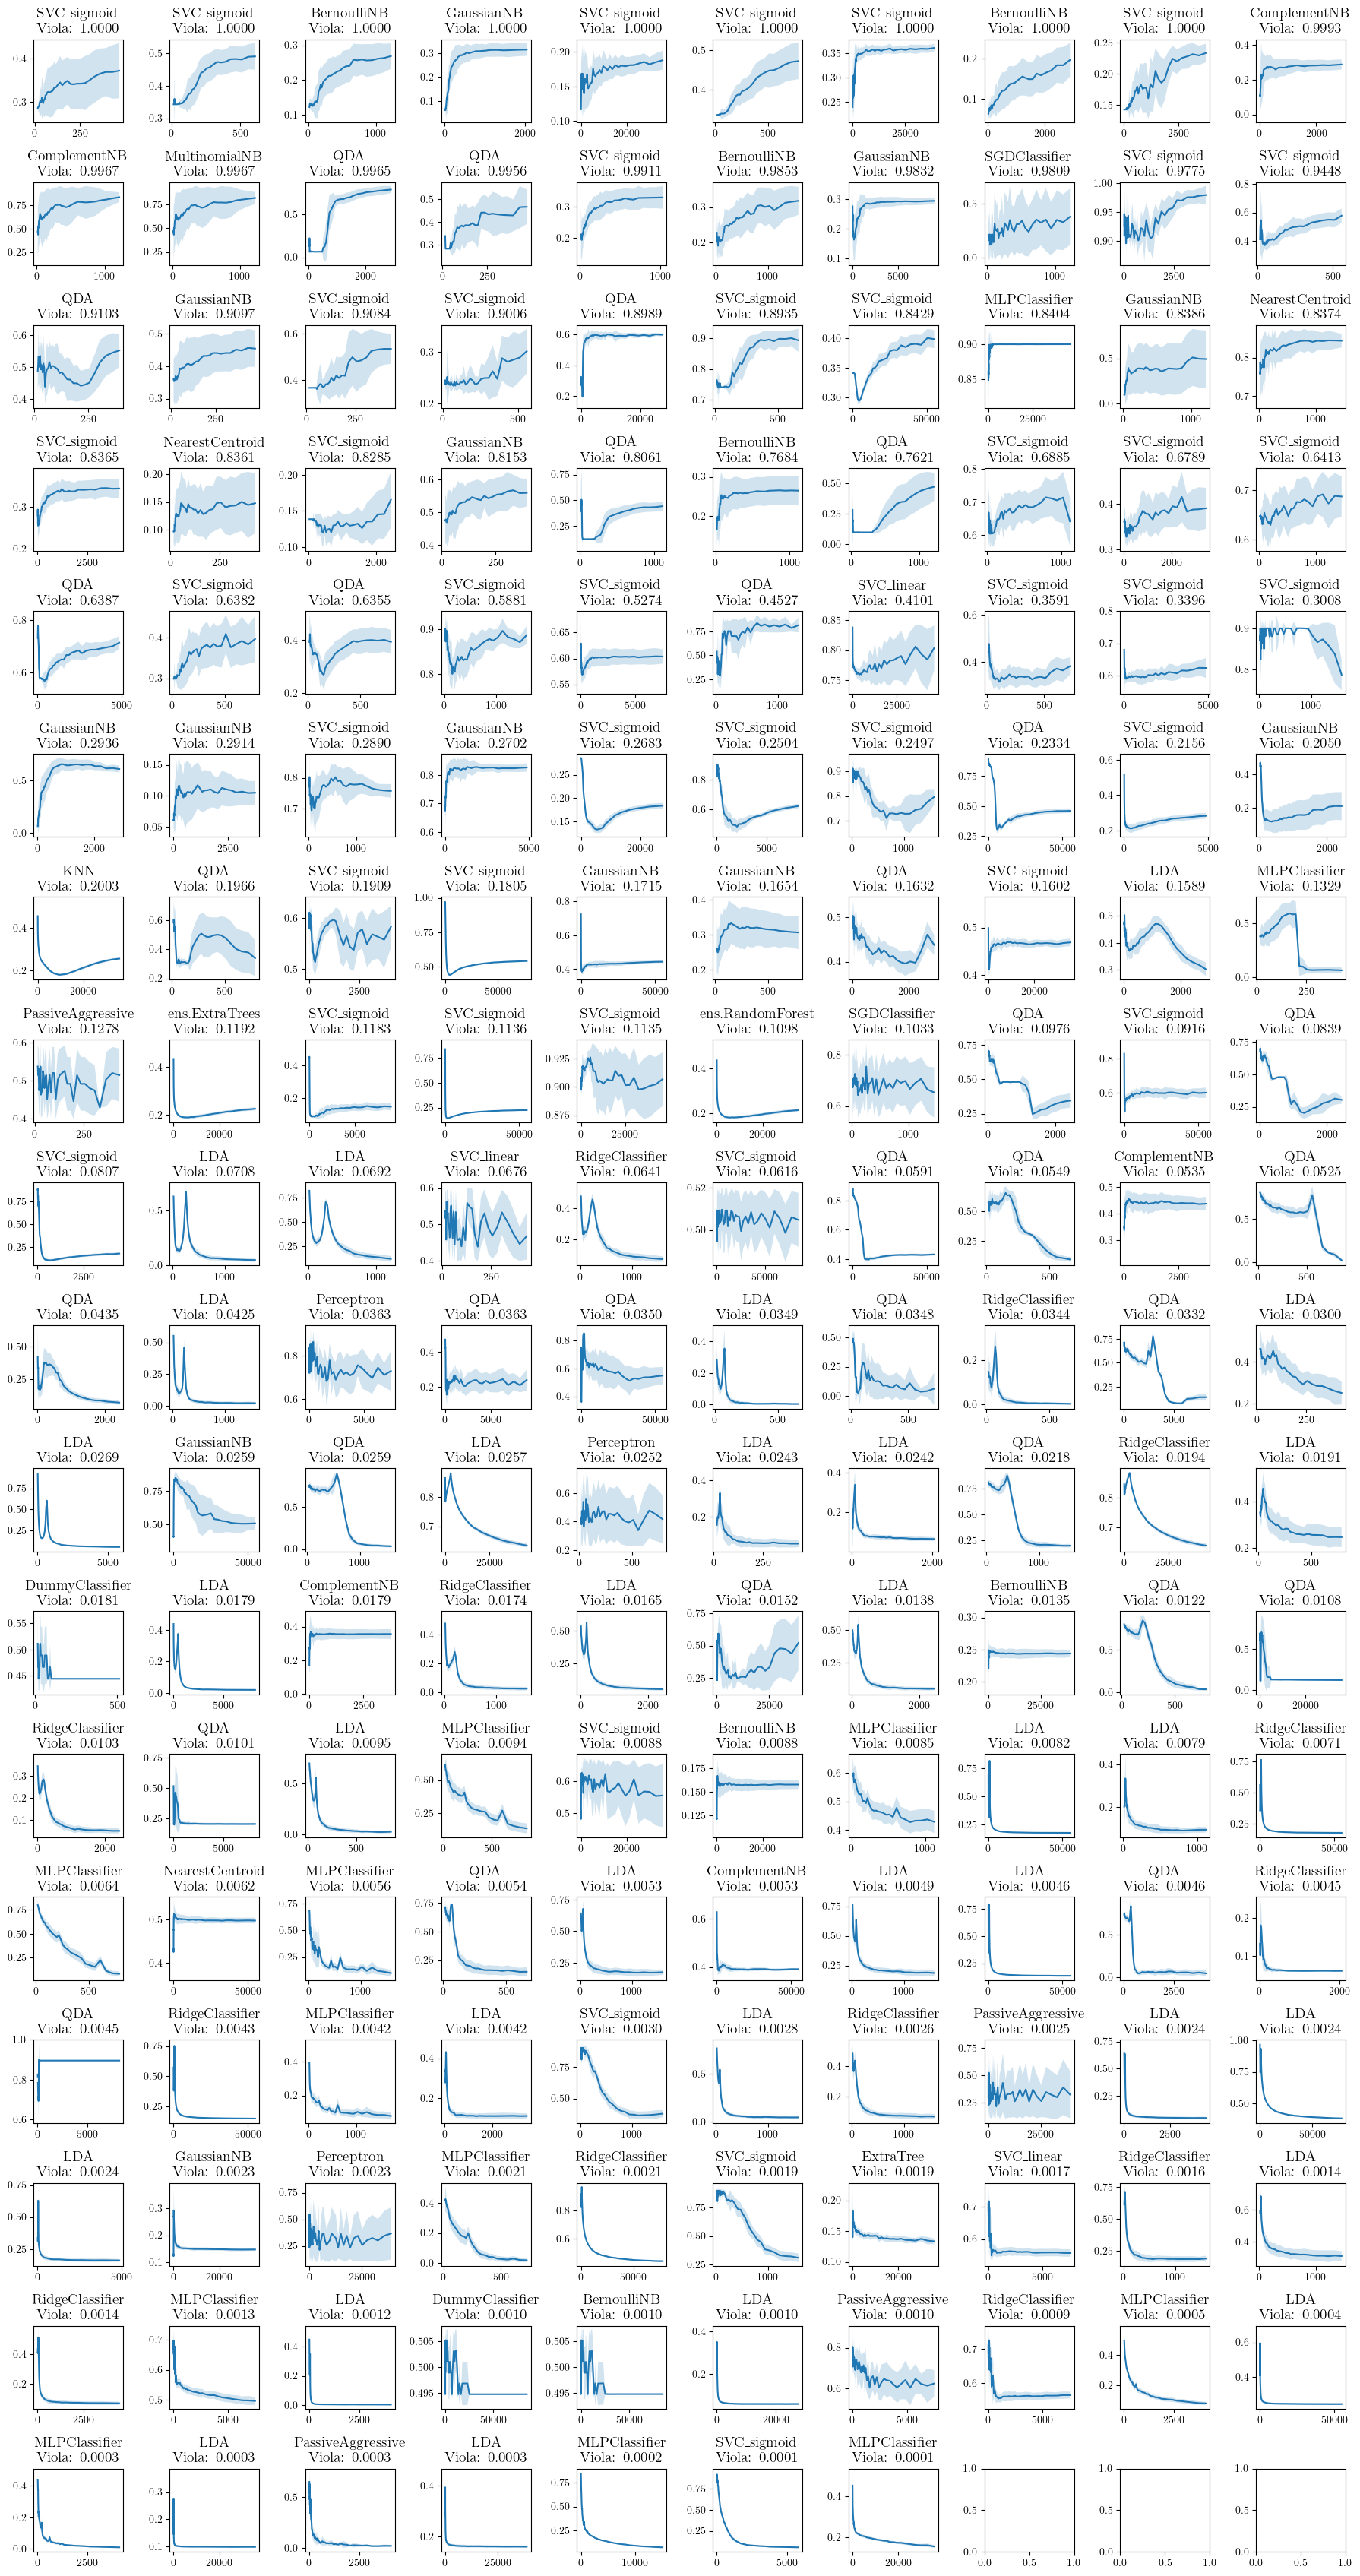

In [ ]:
mono_matrix_xy = mono_matrix_y_nofs * mono_matrix_x_nofs


non_zero_indices = np.nonzero(mono_matrix_xy)

num_non_zero = len(non_zero_indices[0])

# flatten
flattened_matrix = mono_matrix_xy.flatten()
top_indices_flat = np.argpartition(flattened_matrix, - num_non_zero)[- num_non_zero :]
top_indices_flat_sorted = top_indices_flat[np.argsort(-flattened_matrix[top_indices_flat])]

# convert back to 2D
top_indices = np.unravel_index(top_indices_flat_sorted, mono_matrix_xy.shape)


TRAIN_VAL_TEST = 1

fig, axes = plt.subplots((num_non_zero // 10) + 1, 10, figsize=(18, (num_non_zero // 10) * 2))
axes = axes.flatten()
for plot_index in range(num_non_zero): 
    learner_id = top_indices[0][plot_index]
    data_id = top_indices[1][plot_index]
    lc_clean = dataset_nofs[data_id, learner_id, :, :, :, TRAIN_VAL_TEST]
    mean_acc_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
    std_acc_clean = np.nanstd(lc_clean[:, :, :], axis=(0, 1))

    mono = mono_matrix_xy[learner_id, data_id]

    ax = axes[plot_index]
    
    ax.plot(anchor_list_denser, mean_acc_clean)
    ax.fill_between(anchor_list_denser, mean_acc_clean - std_acc_clean, mean_acc_clean + std_acc_clean, alpha=0.2)

    # ax.set_xscale('log')
    # ax.legend(fontsize=8)
    ax.set_title(f"{learner_zoo[learner_id]} \n Viola: {mono:.4f}", fontsize=14)

plt.tight_layout()  
plt.show()


## dipping

In [7]:
mono_matrix_y_nofs, mono_matrix_x_nofs = global_monotonicity_violation(dataset_nofs, dipping=True)
mono_matrix_y_minmaxfs, mono_matrix_x_minmaxfs = global_monotonicity_violation(dataset_minmaxfs, dipping=True)
mono_matrix_y_standardfs, mono_matrix_x_standardfs = global_monotonicity_violation(dataset_standardfs, dipping=True)

  0%|          | 0/72 [00:00<?, ?it/s]c:\Users\cyan1\code\lcdb1.1\analysis\utils.py:331: RuntimeWarning: Mean of empty slice
  mean_curve = np.nanmean(curves_group, axis=0)
 83%|████████▎ | 60/72 [00:00<00:00, 97.04it/s] C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 72/72 [00:00<00:00, 96.39it/s] 


In [8]:
percentages_nofs = (np.sum(mono_matrix_y_nofs > 0, axis=1) / mono_matrix_y_nofs.shape[1]) * 100
percentages_minmaxfs = (np.sum(mono_matrix_y_minmaxfs > 0, axis=1) / mono_matrix_y_minmaxfs.shape[1]) * 100
percentages_standardfs = (np.sum(mono_matrix_y_standardfs > 0, axis=1) / mono_matrix_y_standardfs.shape[1]) * 100


# filter some learner
exclude_indices = [13, 14, 15, 16, 17, 18, 23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

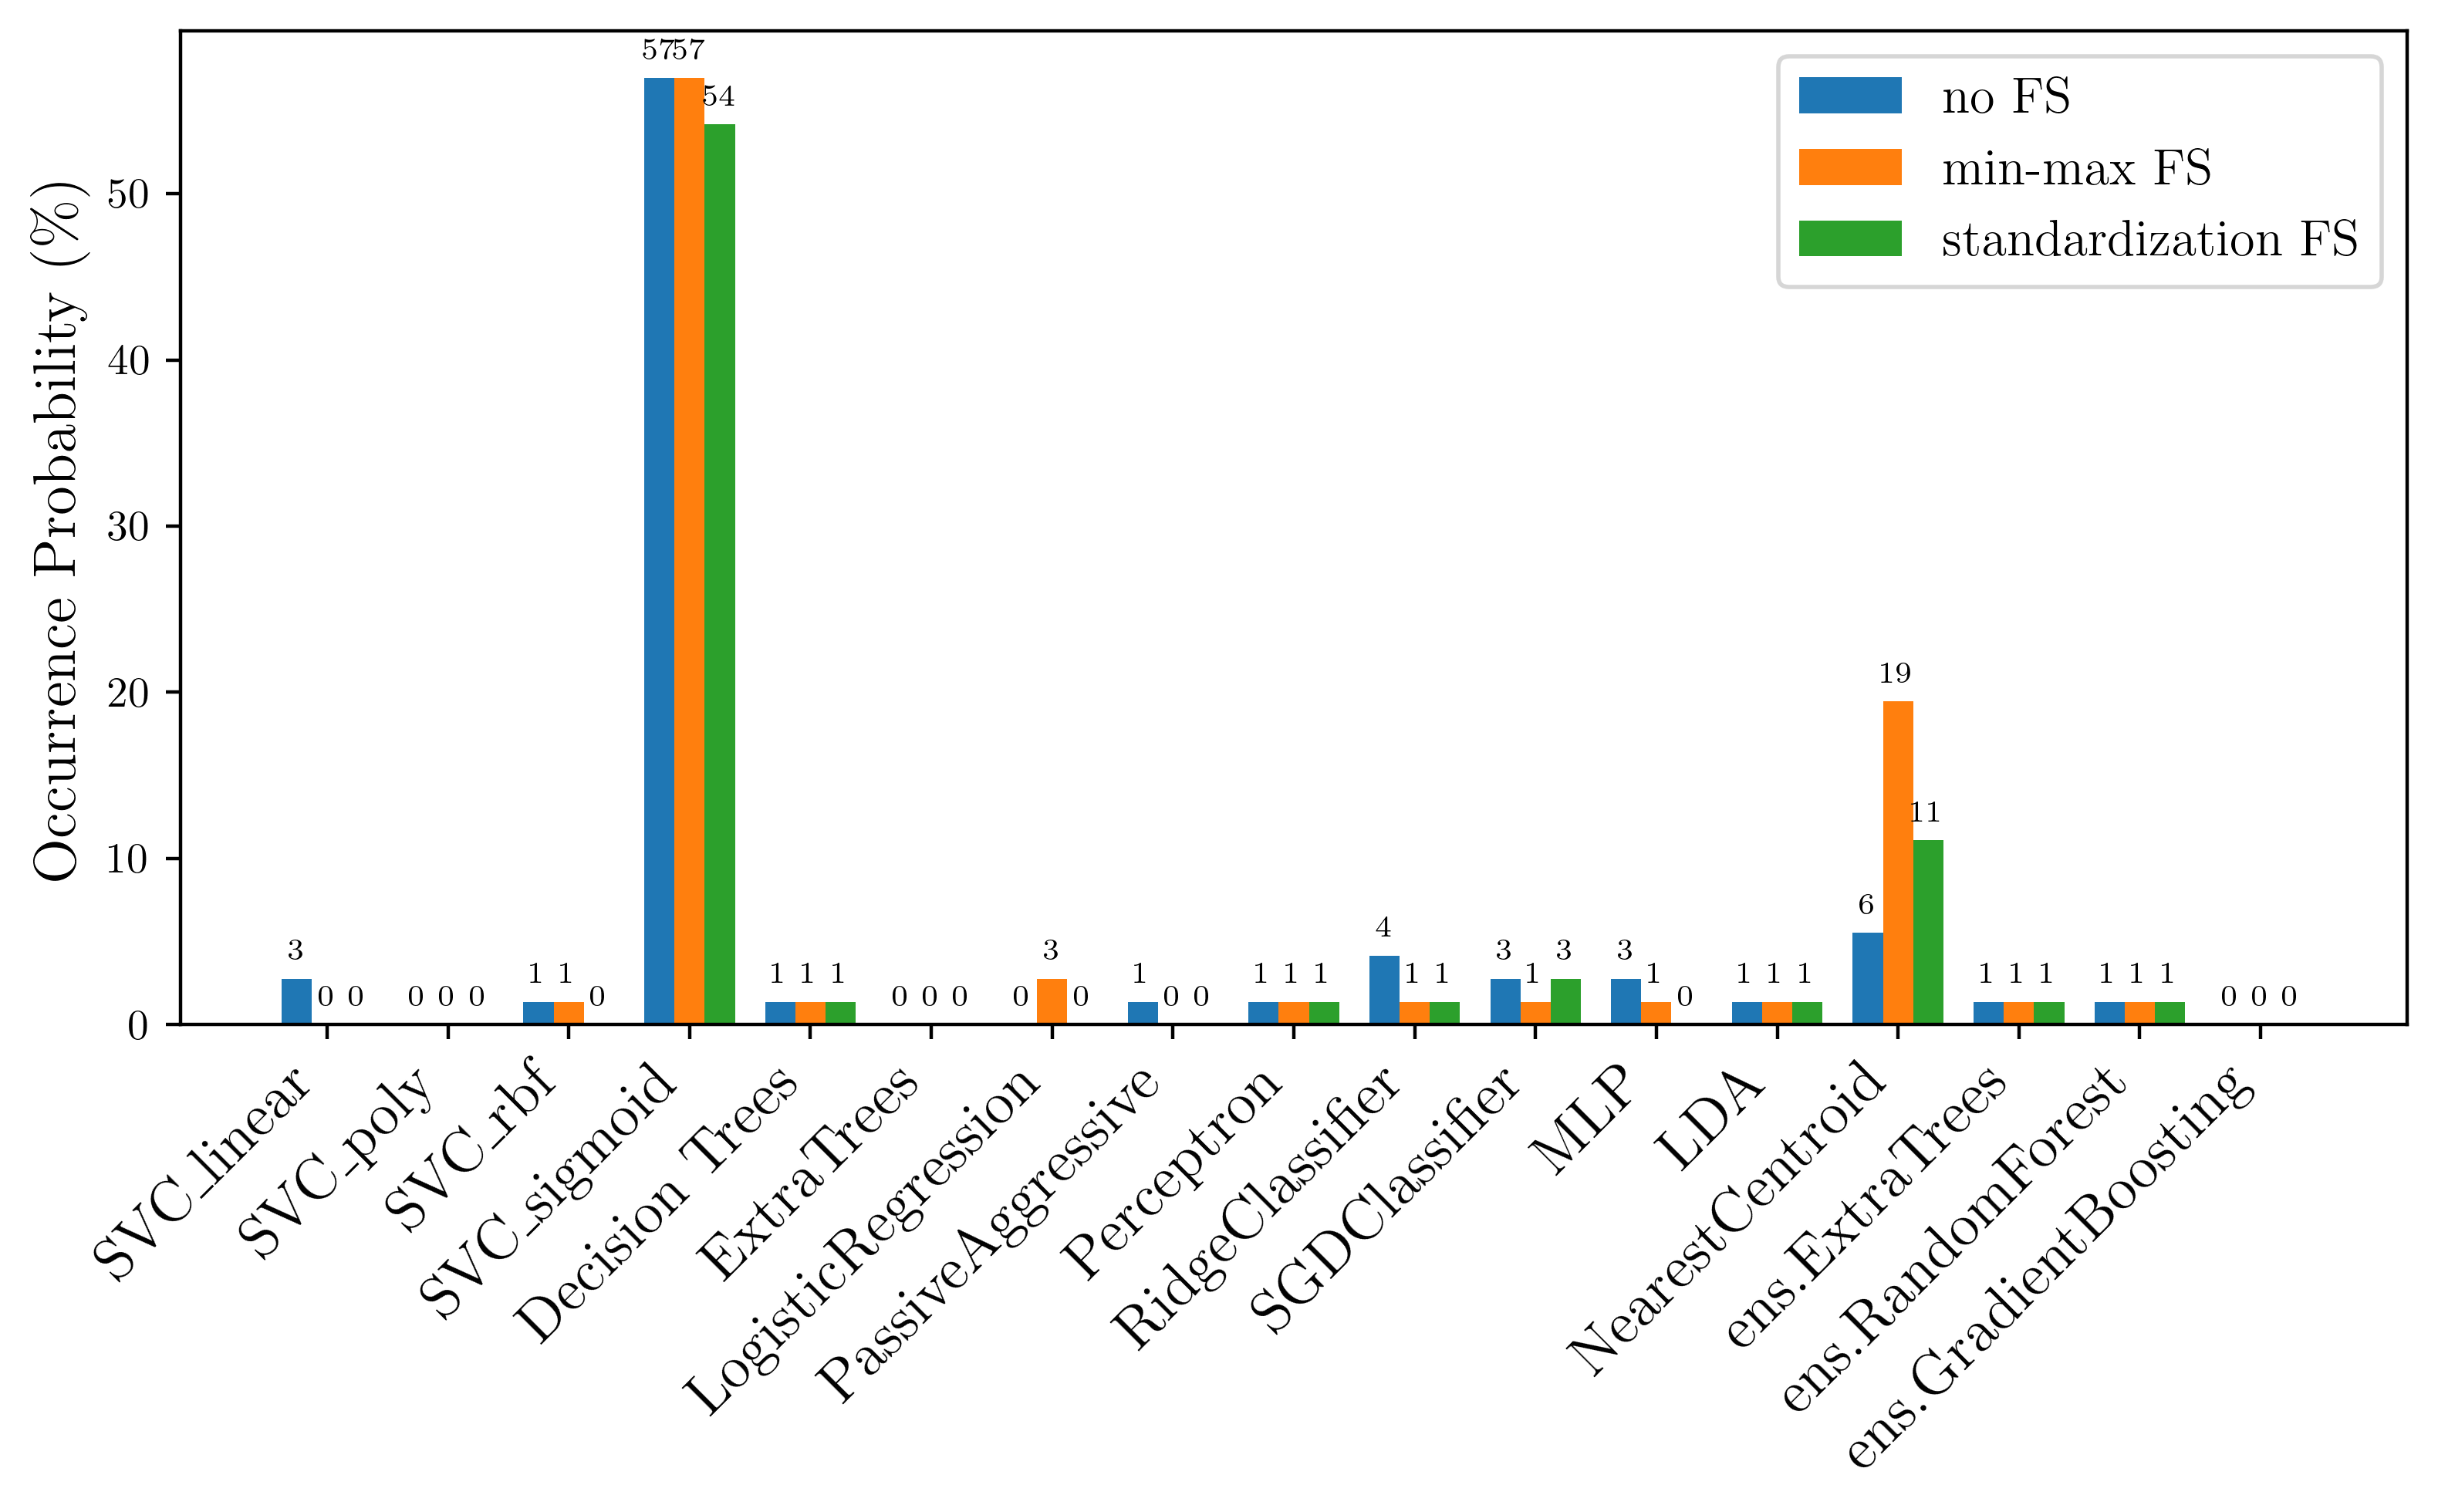

In [9]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Occurrence Probability (\%)', fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(learner_zoo_filtered, rotation=45, ha='right', fontsize = 14)  
ax.legend(fontsize = 12)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()
